<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MODELING" data-toc-modified-id="MODELING-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MODELING</a></span><ul class="toc-item"><li><span><a href="#K-Means-Clustering" data-toc-modified-id="K-Means-Clustering-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>K-Means Clustering</a></span></li><li><span><a href="#Label-Powerset" data-toc-modified-id="Label-Powerset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Label Powerset</a></span><ul class="toc-item"><li><span><a href="#Procedure" data-toc-modified-id="Procedure-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Procedure</a></span></li><li><span><a href="#TF-IDF-+-Linear-SVC" data-toc-modified-id="TF-IDF-+-Linear-SVC-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>TF-IDF + Linear SVC</a></span><ul class="toc-item"><li><span><a href="#Using-all-(1505)-genre-combinations" data-toc-modified-id="Using-all-(1505)-genre-combinations-1.2.2.1"><span class="toc-item-num">1.2.2.1&nbsp;&nbsp;</span>Using all (1505) genre combinations</a></span></li><li><span><a href="#Clustering-to-reduce-complexity" data-toc-modified-id="Clustering-to-reduce-complexity-1.2.2.2"><span class="toc-item-num">1.2.2.2&nbsp;&nbsp;</span>Clustering to reduce complexity</a></span></li></ul></li><li><span><a href="#TF-IDF-+-RandomForest-Classifier" data-toc-modified-id="TF-IDF-+-RandomForest-Classifier-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>TF-IDF + RandomForest Classifier</a></span></li><li><span><a href="#Count-Vectorizer-+-Linear-SVC" data-toc-modified-id="Count-Vectorizer-+-Linear-SVC-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Count Vectorizer + Linear SVC</a></span><ul class="toc-item"><li><span><a href="#Using-all-(1505)-genre-combinations" data-toc-modified-id="Using-all-(1505)-genre-combinations-1.2.4.1"><span class="toc-item-num">1.2.4.1&nbsp;&nbsp;</span>Using all (1505) genre combinations</a></span></li></ul></li><li><span><a href="#TF-IDF-+-Naive-Bayes" data-toc-modified-id="TF-IDF-+-Naive-Bayes-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>TF-IDF + Naive Bayes</a></span><ul class="toc-item"><li><span><a href="#Using-all-1505-Genre-Combinations" data-toc-modified-id="Using-all-1505-Genre-Combinations-1.2.5.1"><span class="toc-item-num">1.2.5.1&nbsp;&nbsp;</span>Using all 1505 Genre Combinations</a></span></li></ul></li></ul></li></ul></li></ul></div>

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cross_validation import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

#plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

from helper_functions import *


C:\Users\smaiya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\smaiya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smaiya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\smaiya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# MODELING

**Loading the input**

In [2]:
mydata_train = pd.read_csv('./../Data/preprocessed/movies_genres_train_preprocessed.csv')
mydata_test = pd.read_csv('./../Data/preprocessed/movies_genres_test_preprocessed.csv')
mydata = pd.read_csv('../Data/movies_genres.csv', delimiter='\t')

train_X, train_y = mydata_train['plot'], mydata_train.drop(['title', 'plot', 'plot_lang'], axis=1)
test_X, test_y = mydata_test['plot'], mydata_test.drop(['title', 'plot', 'plot_lang'], axis=1)

category_columns = train_y.columns

## K-Means Clustering 

In [3]:
print('Number of unique labels = ', train_y.drop_duplicates().shape[0])

Number of unique labels =  1505


Out of the maximum possible 2^27 classes, we see that there are only 1505 unique combinations. Let us use some K-means clustering technique to see how many of these clusters we can reduce them to


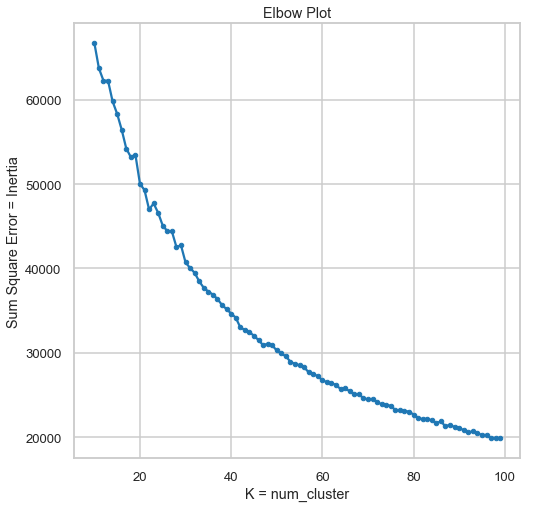

In [20]:
ss = [];
ks = range(10, 100)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(train_y)
    ss.append(kmeans.inertia_)
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(ks, ss, marker='.')
axes.set(xlabel='K = num_cluster', ylabel = 'Sum Square Error = Inertia', title = 'Elbow Plot')
plt.show()

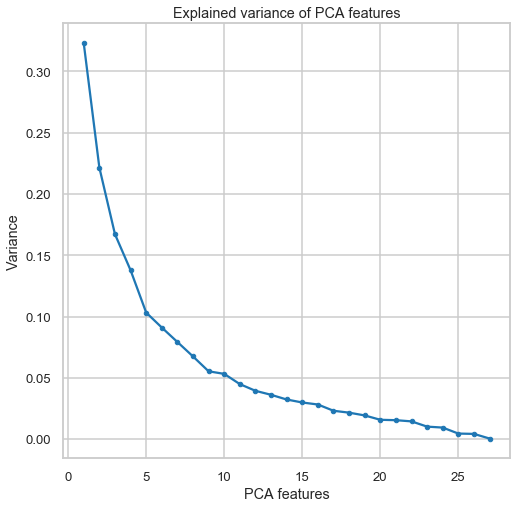

In [21]:
pca = PCA()
pca.fit(train_y)
f, axes = plt.subplots(figsize=(8, 8))
axes.plot(range(1, pca.n_components_+1), pca.explained_variance_, marker = '.')
axes.set(xlabel = 'PCA features', ylabel='Variance', title='Explained variance of PCA features')
plt.show()

Let us use 42 clusters and see represent all the movies belonging to the cluster by their cluster center.

In [22]:
ks = [50, 60, 65, 70, 75, 90, 100]
f1_score = []
thresh = 0.85
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(train_y)
    cluster_center = pd.DataFrame(columns=train_y.columns)
    for cluster_id in range(k):
        cluster_center.loc[cluster_id] = (kmeans.cluster_centers_[cluster_id]>=thresh)*1

    for idx, col in enumerate(train_y.columns):
        max_idx = kmeans.cluster_centers_[:,idx].argmax()
        max_value = kmeans.cluster_centers_[:,idx].max()
        if max_value<thresh:
            cluster_center.loc[max_idx, col] = 1
    
    y_pred = pd.DataFrame(columns=train_y.columns, index=train_y.index)
    for idx in range(k):
        y_pred.loc[labels==idx,:] = cluster_center.loc[idx,:].values

    result = accuracy(train_y, y_pred)
    f1_score.append(result.loc['Avg/Total', 'F1-Score'])

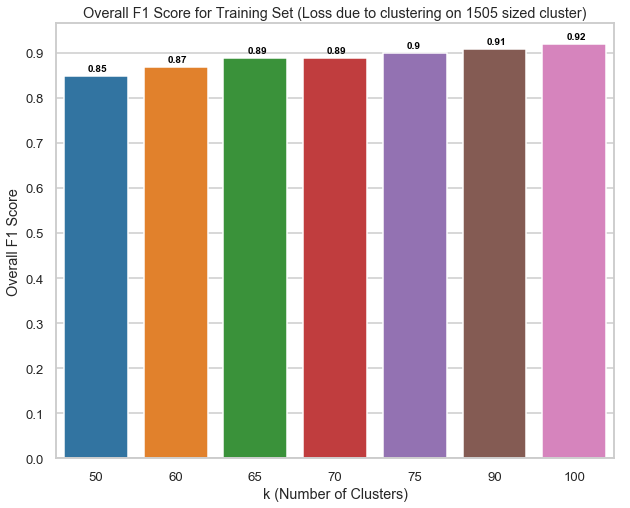

In [50]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.barplot(x=ks, y=f1_score, axes=ax)
ax.set(ylabel='Overall F1 Score', xlabel='k (Number of Clusters)')
ax.set(title='Overall F1 Score for Training Set (Loss due to clustering on 1505 sized cluster)')
plt.yticks(list(np.arange(0, 1, 0.1)))
for idx, val in enumerate(f1_score):
    ax.text(idx-0.1, val + 0.01,  str(val), color='black', fontweight='bold')
plt.show()

Using 75 clusters to represent the labels, we see that the maximum attainable F1 score reduces to 0.9

## Label Powerset

This approach does take partial correlations between genres into account. Here we treat each of the unique genre combinations found in the training data as a possible class. Hence, there can be worst case of 2^n_genres number of classes. 

### Procedure

* Transform (n_rows x n_genres) binary matrix from the training label set into into n_rows x 1 label vector, where the column vector ranges from 0 to num_genre_combinations = number of unique values of genre combinations found in the training data set. 
* Train the classifier using the training data set with labels corresponding to this transformed n_rows x 1 column vector
* Predict the test data set using this fitted classifier. The output would be a column vector with each value ranging from 0 to num_genre_combinations
* Transform this column vector back to individual genres using the inverse mapping that was used in the first step
* Obtain the accuracy (precision/recall/f1 score) of the inverse transformed binary predicted genre matrix


### TF-IDF + Linear SVC

#### Using all (1505) genre combinations 

We have 1505 uniqe genre combinations in our training data set. Let us first transform the training genre matrix (`train_y`) into label vector (`train_y_cluster_labels`). `cluster_center` refers to the mapping between the labels and the genre combination

In [4]:
train_y_cluster_labels= train_y.groupby(list(category_columns)).ngroup()
cluster_center = train_y.copy(deep=True) #pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

In [17]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', LinearSVC(class_weight='balanced'))
            ])
# sorted(pipeline.get_params().keys()) # -- to obtain the GridSearchCV parameter names
parameters = {
                'tfidf__max_df': [0.5],
                'tfidf__ngram_range': [(1, 2)],
                'tfidf__min_df': [2],
                'clf__C': [5, 10, 20, 50, 100]
            }
overall_f1_score_v2_cv = make_scorer(overall_f1_score_v2, greater_is_better=True, class_to_genre_map = cluster_center)
grid_search_cv = GridSearchCV(pipeline, parameters, cv=2, verbose=10, scoring=overall_f1_score_v2_cv)
grid_search_cv.fit(train_X, train_y_cluster_labels)

print()
print("Best parameters set:")
print (grid_search_cv.best_estimator_.steps)
print()

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf = grid_search_cv.best_estimator_
predictions = multi_class_predict(best_clf, test_X, cluster_center) 
accuracy(test_y, predictions)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] clf__C=5, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=5, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.5138000330074656, total= 6.5min
[CV] clf__C=5, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min remaining:    0.0s



[CV]  clf__C=5, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.02269191748393642, total= 6.8min
[CV] clf__C=10, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.6min remaining:    0.0s


[CV]  clf__C=10, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.5373373230497881, total= 5.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.3min remaining:    0.0s


[CV] clf__C=10, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=10, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.02441300533801187, total= 7.1min
[CV] clf__C=20, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 26.6min remaining:    0.0s



[CV]  clf__C=20, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.5534034841202675, total= 5.8min
[CV] clf__C=20, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=20, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.025495923086284532, total= 7.6min
[CV] clf__C=50, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=50, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.5592107814083851, total= 6.5min
[CV] clf__C=50, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=50, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.026749130266718206, total= 8.5min
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.5597463661640708, total=10.9min
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 78.1min finished



Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', LinearSVC(C=100, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]

Applying best classifier on test data:


,Precision,Recall,F1-Score,Support
Action,0.94,0.75,0.83,4321.0
Adult,0.75,0.27,0.40,11.0
Adventure,0.92,0.72,0.81,3496.0
Animation,0.91,0.79,0.85,3333.0
Biography,0.71,0.30,0.42,354.0
Comedy,0.88,0.83,0.85,7320.0
Crime,0.89,0.82,0.86,4453.0
Documentary,0.70,0.74,0.72,1863.0
Drama,0.92,0.87,0.89,11067.0
Family,0.89,0.79,0.84,4173.0


In [73]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=10, class_weight='balanced'))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

,Precision,Recall,F1-Score,Support
Action,0.87,0.82,0.84,4321.0
Adult,0.38,0.27,0.32,11.0
Adventure,0.85,0.80,0.82,3496.0
Animation,0.86,0.84,0.85,3333.0
Biography,0.54,0.43,0.48,354.0
Comedy,0.87,0.84,0.85,7320.0
Crime,0.86,0.86,0.86,4453.0
Documentary,0.72,0.73,0.73,1863.0
Drama,0.91,0.87,0.89,11067.0
Family,0.82,0.84,0.83,4173.0


#### Clustering to reduce complexity

We noticed that we had 1505 unique genre combinations in our data set. Though this is way below the maximum possible combination (which is 2^27 = 134217728), this method, in general, is clearly not very robust with respect to different datasets. To achieve this, we would require a mechanism to control the maximum number of unique genre combinations. One method to go about this is to use clustering.  

* Divide the (n_rows x n_genres) binary matrix into a `k` clusters using any of the well known clustering techniques. In this section we use K-Means
* K-Means would transform the `train_y` input matrix into n_rows labels (ranging from 0 to `k`). 
* The cluster_center (which is the mean of all the observations mapped to that cluster) would be used as a representative genre combination for that cluster (which are all provided the same label)
* Cluster_center are floating values (since they are averaged across several observations) from 0 to 1. Map it to either 0 or 1 using an appropriate threshold
* Some genres might never get included in this cluster_center mapping due to the above rounding operation. This happens when that genre has a very low occurrence. This would result in both precision and recall being 0 for this genre
    * In that case, look for the label which has maximum floating value for that genre and change that `cluster_center[label][genre]` to 1

In [69]:
ks = [75]
f1_score = []
thresh = 0.85
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=2)
    labels = kmeans.fit_predict(train_y)
    train_y_cluster_labels = pd.Series(labels, index=train_y)
    cluster_center = pd.DataFrame(columns=train_y.columns)
    for cluster_id in range(k):
        cluster_center.loc[cluster_id] = (kmeans.cluster_centers_[cluster_id]>=thresh)*1

    for idx, col in enumerate(train_y.columns):
        max_idx = kmeans.cluster_centers_[:,idx].argmax()
        max_value = kmeans.cluster_centers_[:,idx].max()
        if max_value<thresh:
            cluster_center.loc[max_idx, col] = 1
    
    train_y_genre_labels = pd.DataFrame(columns=train_y.columns, index=train_y.index)
    for idx in range(k):
        train_y_genre_labels.loc[labels==idx,:] = cluster_center.loc[idx,:].values

    result = accuracy(train_y, train_y_genre_labels)

In [27]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', LinearSVC(class_weight='balanced'))
            ])
# sorted(pipeline.get_params().keys()) # -- to obtain the GridSearchCV parameter names
parameters = {
                'tfidf__max_df': [0.25, 0.5, 0.75],
                'tfidf__ngram_range': [(1, 2)],
                'tfidf__min_df': [1, 2, 5],
                'clf__C': [1, 10, 100]
            }
overall_f1_score_v2_cv = make_scorer(overall_f1_score_v2, greater_is_better=True, class_to_genre_map = cluster_center)
grid_search_cv = GridSearchCV(pipeline, parameters, cv=2, verbose=10, scoring=overall_f1_score_v2_cv)
grid_search_cv.fit(train_X, train_y_cluster_labels)

print()
print("Best parameters set:")
print (grid_search_cv.best_estimator_.steps)
print()

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf = grid_search_cv.best_estimator_
predictions = multi_class_predict(best_clf, test_X, cluster_center) 
accuracy(test_y, predictions)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.14074724653482337, total= 2.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.14213485992198185, total= 1.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.1min remaining:    0.0s


[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.13800695131025065, total=  50.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.1min remaining:    0.0s


[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.1421442551054913, total=  45.2s
[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.0min remaining:    0.0s



[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.13180667270009455, total=  35.7s
[CV] clf__C=1, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.25, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.13577076709872013, total=  37.2s
[CV] clf__C=1, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.14079360432838384, total= 1.5min
[CV] clf__C=1, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.14251820006894733, total= 1.4min
[CV] clf__C=1, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=1, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.13799918500407501, total=  47.8s
[CV] clf__C=1, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2) 
[CV]  

[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 2), score=0.16911001849429386, total= 3.6min
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.15568038260241834, total= 2.2min
[CV] clf__C=100, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=100, tfidf__max_df=0.5, tfidf__min_df=5, tfidf__ngram_range=(1, 2), score=0.15690095417282623, total= 2.1min
[CV] clf__C=100, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=100, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.17903846370826706, total=11.4min
[CV] clf__C=100, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2) 
[CV]  clf__C=100, tfidf__max_df=0.75, tfidf__min_df=1, tfidf__ngram_range=(1, 2), score=0.1776445319491677, total=10.3min
[CV] clf__C=100, tfidf__max_df=0.75, tfidf__min_df=2, tfidf__ngram_

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 166.1min finished



Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', LinearSVC(C=100, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]

Applying best classifier on test data:


,Precision,Recall,F1-Score,Support
Action,0.93,0.51,0.65,4321.0
Adult,0.00,0.09,0.00,11.0
Adventure,0.91,0.49,0.63,3496.0
Animation,0.92,0.62,0.74,3333.0
Biography,0.75,0.03,0.06,354.0
Comedy,0.85,0.67,0.75,7320.0
Crime,0.89,0.73,0.80,4453.0
Documentary,0.68,0.63,0.66,1863.0
Drama,0.89,0.77,0.83,11067.0
Family,0.91,0.55,0.69,4173.0


In [70]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 1))),
                ('clf', LinearSVC(C=1, class_weight='balanced'))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

,Precision,Recall,F1-Score,Support
Action,0.82,0.57,0.67,4321.0
Adult,0.00,0.09,0.00,11.0
Adventure,0.80,0.54,0.64,3496.0
Animation,0.83,0.68,0.75,3333.0
Biography,0.38,0.09,0.15,354.0
Comedy,0.86,0.65,0.74,7320.0
Crime,0.82,0.77,0.80,4453.0
Documentary,0.68,0.55,0.61,1863.0
Drama,0.90,0.74,0.81,11067.0
Family,0.80,0.62,0.70,4173.0


In [71]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2))),
                ('clf', LinearSVC(C=10, class_weight='balanced'))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

,Precision,Recall,F1-Score,Support
Action,0.90,0.53,0.67,4321.0
Adult,0.00,0.09,0.00,11.0
Adventure,0.89,0.50,0.64,3496.0
Animation,0.90,0.65,0.75,3333.0
Biography,0.58,0.06,0.11,354.0
Comedy,0.85,0.67,0.75,7320.0
Crime,0.88,0.74,0.81,4453.0
Documentary,0.69,0.62,0.65,1863.0
Drama,0.90,0.76,0.82,11067.0
Family,0.88,0.58,0.70,4173.0


### TF-IDF + RandomForest Classifier
Random Forest Classifier seem to require a lot of memory. Hit memory error even for 500 estimators

In [101]:
train_y_cluster_labels = pd.DataFrame(columns=['Labels'], index=train_y.index)
train_y_cluster_labels['Labels'] = train_y.groupby(list(category_columns)).ngroup()
cluster_center = pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

In [ ]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 1))),
                ('clf', RandomForestClassifier(n_estimators=500, max_depth=70, max_features='sqrt', n_jobs=4))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

### Count Vectorizer + Linear SVC

#### Using all (1505) genre combinations

In [17]:
train_y_cluster_labels= train_y.groupby(list(category_columns)).ngroup()
cluster_center = train_y.copy(deep=True) #pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)

In [32]:
pipeline = Pipeline([
                ('cvec', CountVectorizer()),
                ('clf', LinearSVC(class_weight='balanced'))
            ])
# sorted(pipeline.get_params().keys()) # -- to obtain the GridSearchCV parameter names
parameters = {
                'cvec__max_df': [0.25, 0.5],
                'cvec__ngram_range': [(1, 1)],
                'cvec__min_df': [1, 2],
                'clf__C': [1, 10, 50, 100]
            }
overall_f1_score_v2_cv = make_scorer(overall_f1_score_v2, greater_is_better=True, class_to_genre_map = cluster_center)
grid_search_cv = GridSearchCV(pipeline, parameters, cv=2, verbose=10, scoring=overall_f1_score_v2_cv)
grid_search_cv.fit(train_X, train_y_cluster_labels)

print()
print("Best parameters set:")
print (grid_search_cv.best_estimator_.steps)
print()

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf = grid_search_cv.best_estimator_
predictions = multi_class_predict(best_clf, test_X, cluster_center) 
accuracy(test_y, predictions)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] clf__C=1, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1) 
[CV]  clf__C=1, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.5052037729319918, total= 4.3min
[CV] clf__C=1, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min remaining:    0.0s


[CV]  clf__C=1, cvec__max_df=0.25, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.02354375854370937, total= 5.4min
[CV] clf__C=1, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.9min remaining:    0.0s


[CV]  clf__C=1, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.4999895763842561, total= 3.9min
[CV] clf__C=1, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1) 
[CV]  clf__C=1, cvec__max_df=0.25, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.023113633933691667, total= 4.3min
[CV] clf__C=1, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1) 
[CV]  clf__C=1, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.5062047759721691, total= 3.5min
[CV] clf__C=1, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1) 
[CV]  clf__C=1, cvec__max_df=0.5, cvec__min_df=1, cvec__ngram_range=(1, 1), score=0.023440274653723215, total= 4.5min
[CV] clf__C=1, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1) 
[CV]  clf__C=1, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1), score=0.5011450600700078, total= 3.0min
[CV] clf__C=1, cvec__max_df=0.5, cvec__min_df=2, cvec__ngram_range=(1, 1) 
[CV]  clf__C=1, cvec__max_df=0.5, cvec

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 123.7min finished



Best parameters set:
[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]

Applying best classifier on test data:


,Precision,Recall,F1-Score,Support
Action,0.83,0.76,0.79,4321.0
Adult,0.75,0.27,0.40,11.0
Adventure,0.80,0.72,0.76,3496.0
Animation,0.82,0.78,0.80,3333.0
Biography,0.46,0.37,0.41,354.0
Comedy,0.85,0.79,0.82,7320.0
Crime,0.82,0.81,0.81,4453.0
Documentary,0.65,0.65,0.65,1863.0
Drama,0.89,0.84,0.86,11067.0
Family,0.79,0.78,0.79,4173.0


In [18]:
pipeline = Pipeline([
                ('cvec', CountVectorizer(max_df=0.75, min_df=1, ngram_range=(1, 1))),
                ('clf', LinearSVC(C=1, class_weight='balanced'))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

,Precision,Recall,F1-Score,Support
Action,0.83,0.76,0.79,4321.0
Adult,0.75,0.27,0.40,11.0
Adventure,0.80,0.72,0.76,3496.0
Animation,0.82,0.78,0.80,3333.0
Biography,0.46,0.37,0.41,354.0
Comedy,0.85,0.79,0.82,7320.0
Crime,0.82,0.81,0.81,4453.0
Documentary,0.65,0.65,0.65,1863.0
Drama,0.89,0.84,0.86,11067.0
Family,0.79,0.78,0.79,4173.0


### TF-IDF + Naive Bayes

#### Using all 1505 Genre Combinations

In [5]:
train_y_cluster_labels= train_y.groupby(list(category_columns)).ngroup()
cluster_center = train_y.copy(deep=True) #pd.DataFrame(train_y)
cluster_center['Labels']=train_y_cluster_labels
cluster_center = cluster_center.drop_duplicates()
cluster_center = cluster_center.reset_index().set_index(['Labels']).sort_index().drop('index', axis=1)


In [25]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', MultinomialNB(fit_prior=True, class_prior=None))
            ])
# sorted(pipeline.get_params().keys()) # -- to obtain the GridSearchCV parameter names
parameters = {
                'tfidf__max_df': [0.25, 0.5, 0.75],
                'tfidf__ngram_range': [(1, 1)],
                'tfidf__min_df': [1, 2, 5, 10],
                'clf__alpha': [0.001, 0.01, 0.1, 1]
            }

overall_f1_score_v2_cv = make_scorer(overall_f1_score_v2, greater_is_better=True, class_to_genre_map = cluster_center)
grid_search_cv = GridSearchCV(pipeline, parameters, cv=2, scoring=overall_f1_score_v2_cv)
grid_search_cv.fit(train_X, train_y_cluster_labels)

print()
print("Best parameters set:")
print (grid_search_cv.best_estimator_.steps)
print()

# measuring performance on test set
print ("Applying best classifier on test data:")
best_clf = grid_search_cv.best_estimator_
predictions = multi_class_predict(best_clf, test_X, cluster_center) 
accuracy(test_y, predictions)


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))]

Applying best classifier on test data:


,Precision,Recall,F1-Score,Support
Action,0.98,0.39,0.56,4321.0
Adult,0.00,0.00,0.00,11.0
Adventure,0.96,0.31,0.46,3496.0
Animation,0.92,0.43,0.58,3333.0
Biography,0.89,0.05,0.09,354.0
Comedy,0.72,0.73,0.72,7320.0
Crime,0.90,0.55,0.69,4453.0
Documentary,0.46,0.64,0.54,1863.0
Drama,0.89,0.75,0.81,11067.0
Family,0.96,0.38,0.54,4173.0


In [30]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 1))),
                ('clf', MultinomialNB(alpha=0.001, fit_prior=True, class_prior=None))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

,Precision,Recall,F1-Score,Support
Action,0.98,0.37,0.53,4321.0
Adult,0.00,0.00,0.00,11.0
Adventure,0.98,0.31,0.47,3496.0
Animation,0.95,0.41,0.57,3333.0
Biography,0.96,0.07,0.13,354.0
Comedy,0.68,0.71,0.69,7320.0
Crime,0.90,0.46,0.61,4453.0
Documentary,0.42,0.60,0.49,1863.0
Drama,0.87,0.72,0.79,11067.0
Family,0.95,0.35,0.51,4173.0


In [27]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 1))),
                ('clf', MultinomialNB(alpha=0.001, fit_prior=True, class_prior=None))
            ])
pipeline.fit(train_X, train_y_cluster_labels)
predictions = multi_class_predict(pipeline, test_X, cluster_center) 
accuracy(test_y, predictions)

,Precision,Recall,F1-Score,Support
Action,0.98,0.44,0.61,4321.0
Adult,0.00,0.00,0.00,11.0
Adventure,0.98,0.37,0.54,3496.0
Animation,0.95,0.48,0.63,3333.0
Biography,0.92,0.09,0.17,354.0
Comedy,0.72,0.73,0.72,7320.0
Crime,0.91,0.53,0.67,4453.0
Documentary,0.46,0.63,0.53,1863.0
Drama,0.88,0.75,0.81,11067.0
Family,0.95,0.41,0.57,4173.0
